In [1]:
import levinpower
import numpy as np
import time
import matplotlib.pyplot as plt


Let us define an integral of the type
$$ I(y) = \int j_\ell(xk) f(x) \mathrm{d}x\,, $$
which we integrante from $x=10^{-5}$ to $100$. For the function we assume $f(x) = (x^3 - x^2 + x)x$.

In [2]:
x = np.geomspace(1e-5,100,100) #define support
from scipy import special
f_of_x = (x**3 -x**2 +x)[:, None]*x[None, :] #define f(x) 
#f_of_x = np.exp(-x**2/10)[:, None]*x[None, :]
#plt.loglog(x, f_of_x)
# define integral type for Levin, 0 correpsonds to single spherical Bessel function 
# 0: single spherical Bessel function
# 1: single cylindrical Bessel function
# 2: double spherical Bessel function
# 3: double cylindrical Bessel function
# 4: triple spherical Bessel function
# 5: triple cylindrical Bessel function
integral_type = 0 
N_thread = 8 # Number of threads used for hyperthreading
logx = True # Tells the code to create a logarithmic spline in x for f(x)
logy = True # Tells the code to create a logarithmic spline in y for y = f(x)
lp = levinpower.levinpower(integral_type, x, f_of_x, logx, logy, N_thread) #Constructor of the class
n_sub = 8 #number of collocation points in each bisection
n_bisec_max = 8 #maximum number of bisections used
rel_acc = 1e-4 #relative accuracy target
boost_bessel = True #should the bessel functions be calculated with boost instead of GSL, higher accuracy at high Bessel orders
verbose = False #should the code talk to you?
lp.set_levin(n_sub, n_bisec_max, rel_acc, boost_bessel, verbose) #constructor





We have now initiated the levin CLASS and the spline for the integrand is set as well as the integral type, which we choose to be the one displayed on top (the type cannot be changed in the same instance of levinpower). The code checks internally if a logarithmic spline can be created, i.e. if $f(x)$ is positive everywhere. If this is not the case the code falls back to a linear spline. You can of course always set `logx = False` and `logy = False` for double linear interpolation. 

Note that we simply pretend to have many integrands $f(x)$ we of the integral type above by broadcasting: `(x**3 -x**2 +x)[:, None]*x[None, :]`. In prinicple the code simply expects the support `x` and the integrand `f_of_x` which should have shape `(len(x),#number integrands)`. Pay attention that the second dimension always must be around even for a single integrand. So you could for example pass `x` and `f_of_x[:, None]`, if `f_of_x` is a simple 1d array.

In the last line we set the levin parameters specifically. In particular the number of collocation points (`8`), the maximum number of bisections (`32`) the relative accuracy required (`1e-6`), if highest accuracy for the bessel functions is required (`False`) and if the code should talk to you (`False`). Note that the high accuracy setting for the Bessel function is usually not needed. If you encounter weird behaviour though and do not get a convergence warning, you might turn this parameter to `True`. This will slow down the code for the first two calls of the integration significantly, especially at high $\ell$. 

In [3]:
N = 500 #number of arguments/orders at which the integral is evaluted
k = np.geomspace(1e-3,100,N)
order = 5
ell = (order*np.ones_like(k)).astype(int) #we keep the order of the bessel function fixed, but vary argument k

t0 = time.time()
result_levin = np.array(lp.levin_integrate_bessel_single(x[0]*np.ones_like(k), x[-1]*np.ones_like(k), k, ell, False)) 
print("Levin took", time.time() -t0, "s")


Levin took 1.505615234375 s


We now can estimate the integral for the first time and call the function `levin_integrate_bessel_single`. This takes four 1D numpy arrays of the same length which are the lower integration limit, the upper integration limit, the multiplicative argument in the Bessel function and the order of the Bessel function under consideration. The function returns a 2d list with the length of the arguments as rows and the columns being the results for each integrand passed in the constructor.

In [4]:
t0 = time.time()
result_levin_rerun = np.array(lp.levin_integrate_bessel_single(x[0]*np.ones_like(k),x[-1]*np.ones_like(k),k,ell, False))
print("Levin took", time.time() -t0, "s")


Levin took 0.9130029678344727 s


Next we rerun the integrand and it calculates the integrand given the bisection of the first run. This you can always do if you update the integrand in such a way that the bisection wouldn't change for a given accuracy. This usually is the case if the function $f(x)$ does not dramatically changes its assymptotic behaviour.

In [5]:
t0 = time.time()
result_levin_rererun = np.array(lp.levin_integrate_bessel_single(x[0]*np.ones_like(k),x[-1]*np.ones_like(k),k,ell, False))
print("Levin took", time.time() -t0, "s")



Levin took 0.3179640769958496 s


Lastly, we rerun the integral again and it uses the precomputed LU decomposition and Bessel functions for the bisection which was already used. Speeding up the integration by a factor of ten

Trapeziodal took 5.759386777877808 s


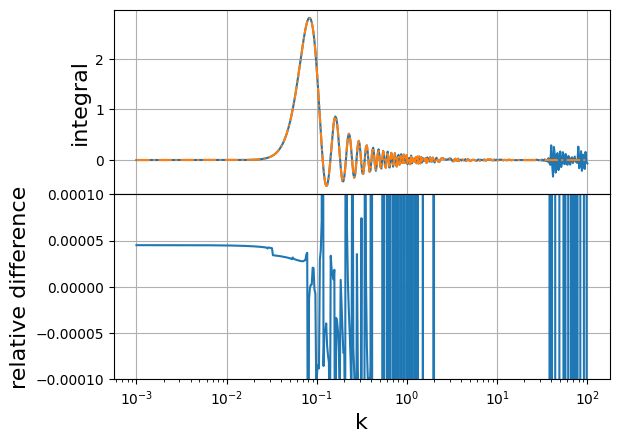

In [6]:
from scipy.special import spherical_jn, jv

trapz_result = np.zeros_like(result_levin)

N_trapz = int(1e4)
trapz_x = np.geomspace(1e-5,100,N_trapz)
trapz_of_x = (trapz_x**3 -trapz_x**2 +trapz_x)[:, None]*x[None, :]

t0 = time.time()
for k_i, k_val in enumerate(k):
    integrand = trapz_of_x* spherical_jn(order,k_val*trapz_x)[:, None]
    trapz_result[k_i, :] = np.trapz(integrand, trapz_x, axis = 0)
print("Trapeziodal took", time.time() -t0, "s")

fig, ax = plt.subplots(2)
ax[0].semilogx(k,trapz_result[:,0]*k)
ax[0].semilogx(k,result_levin_rererun[:,0]*k, ls = "-.")
ax[0].set_ylabel("integral", fontsize = 16)
ax[0].grid(axis = "both")

ax[1].semilogx(k, (trapz_result[:,0] - result_levin_rererun[:,0])/result_levin_rererun[:,0])
ax[1].set_xlabel("k", fontsize = 16)
ax[1].set_ylabel("relative difference", fontsize = 16)
ax[1].set_ylim(-1e-4,1e-4)
ax[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)


Now we compare the result to a simple trapeziodal integration rule with $N=10^4$ sampling points. We can see that at low $k$ both methods agree very well. At higher $k$ values, however, Levin's method (orange) performs much better then the trapezoidal integration. Increasing the number of evaluation points can increase the accuracy of the latter. It is, however, assuming the precomputed bisection, already over 20 times slower. To reach the same accuracy we would have to set $N>10^5$, adding at least another order of magnitude to the comoutation time.

Levin took 0.16810178756713867 s
Trapeziodal took 5.909296989440918 s


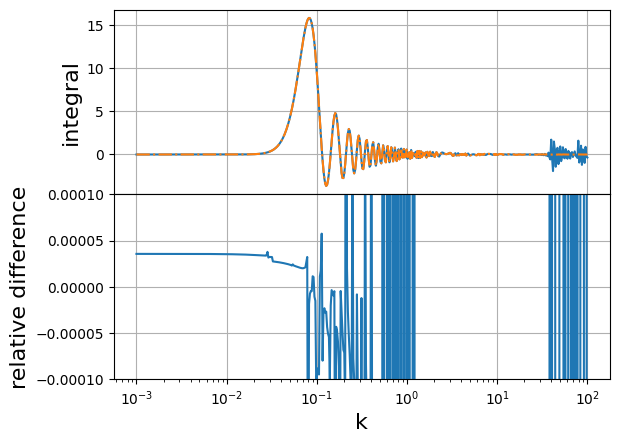

In [7]:
x = np.geomspace(1e-5,100,100)
y = (1.5*x**3.3 -0.69*x**2.5 +x**1.5)[:, None]*x[None, :]
integral_type = 0
N_thread = 8
lp.update_integrand(x,y, True, True)

t0 = time.time()
result_levin_rererun = np.array(lp.levin_integrate_bessel_single(x[0]*np.ones_like(k),x[-1]*np.ones_like(k),k,ell, False))
print("Levin took", time.time() -t0, "s")

trapz_result = np.zeros_like(result_levin)

t0 = time.time()

N_trapz = int(1e4)
trapz_x = np.geomspace(1e-5,100,N_trapz)
trapz_of_x = (1.5*trapz_x**3.3 -0.69*trapz_x**2.5 + trapz_x**1.5)[:, None]*x[None, :]


for k_i, k_val in enumerate(k):
    integrand = trapz_of_x* spherical_jn(order,k_val*trapz_x)[:, None]
    trapz_result[k_i, :] = np.trapz(integrand, trapz_x, axis = 0)

print("Trapeziodal took", (time.time() -t0), "s")

fig, ax = plt.subplots(2)
ax[0].semilogx(k,trapz_result[:,0]*k)
ax[0].semilogx(k,result_levin_rererun[:,0]*k, ls = "-.")
ax[0].set_ylabel("integral", fontsize = 16)
ax[0].grid(axis = "both")
#ax[0].set_xticks([])

ax[1].semilogx(k, (trapz_result[:,0] - result_levin_rererun[:,0])/result_levin_rererun[:,0])
ax[1].set_xlabel("k", fontsize = 16)
ax[1].set_ylabel("relative difference", fontsize = 16)
ax[1].set_ylim(-1e-4,1e-4)
ax[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)


Rerunning the integral for the same integrand would be rather pointless. To make use of the precoputed bisection we do not use a new instance of levin, but rather update the integrand by hand, using the `update_integrand` method which requires again the support, the integrand and whether logarithmic splining in $x$ and $y$ should be used. The reason this works rather well is that the bisection itself is largely governed by the type of integral which is solved, i.e. by the oscillatory function itself. The function $f(x)$ only enters the game as an inhomogeneity in a linear system of equations.

